<a href="https://colab.research.google.com/github/xphoenixx32/case_study/blob/main/data_mining_on_sales_data_of_klook_hotel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prepare

### import packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# plt.style.available
plt.style.use('ggplot')

### Import Dataset

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/case_study_klook_20240923.csv')
df.head(5)

,Hotel Name,City,Gross-Sales,Gross_booking,Gross Margin,Direct supply Revenue share,Traffic,Hotel CVR,BM
0,40273_847190 - Kingsford Hotel Manila,Metro Manila,"$22,658",199,6.3%,18.6%,37536,0.5%,35.14%
1,40273_573698 - Okada Manila,Metro Manila,"$14,922",128,6.1%,76.2%,41317,0.3%,12.81%
2,40273_270646 - La Carmela de Boracay Resort Hotel,Boracay,"$16,417",195,4.9%,44.2%,51746,0.4%,22.07%
3,40273_495358 - Fairways and Bluewater Boracay,Boracay,"$9,805",123,5.0%,0.0%,48271,0.3%,81.05%
4,40273_273082 - Henann Regency Resort & Spa,Boracay,"$28,499",239,6.7%,67.5%,40533,0.6%,28.87%


### Dealing Column type

In [ ]:
%%time
df['index_n_name'] = df['Hotel Name']
df['hotel_index'] = df['Hotel Name'].apply(lambda x: x.split(' - ')[0])
df['hotel_name'] = df['Hotel Name'].apply(lambda x: x.split(' - ')[1])
df['gross_sale'] = df['Gross-Sales'].apply(lambda x: int(x.replace(',','').split('$')[1]))
df['gross_margin'] = df['Gross Margin'].apply(lambda x: float(x.replace('%',''))*0.01)
df['direct_supply_revenue_share'] = df['Direct supply Revenue share'].apply(lambda x: float(x.replace('%',''))*0.01)
df['hotel_cvr'] = df['Hotel CVR'].apply(lambda x: float(x.replace('%',''))*0.01)
df['beat_or_meet'] = df['BM'].apply(lambda x: float(x.replace('%',''))*0.01)
df['gross_booking'] = df['Gross_booking']
df['traffic'] = df['Traffic']
df['city'] = df['City']
df.columns

CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 49.4 ms


Index(['Hotel Name', 'City', 'Gross-Sales', 'Gross_booking', 'Gross Margin',
       'Direct supply Revenue share', 'Traffic', 'Hotel CVR', 'BM',
       'index_n_name', 'hotel_index', 'hotel_name', 'gross_sale',
       'gross_margin', 'direct_supply_revenue_share', 'hotel_cvr',
       'beat_or_meet', 'gross_booking', 'traffic', 'city'],
      dtype='object')

In [ ]:
df.dtypes

,0
Hotel Name,object
City,object
Gross-Sales,object
Gross_booking,int64
Gross Margin,object
Direct supply Revenue share,object
Traffic,int64
Hotel CVR,object
BM,object
index_n_name,object


In [ ]:
df.isna().sum()

,0
Hotel Name,0
City,20
Gross-Sales,0
Gross_booking,0
Gross Margin,0
Direct supply Revenue share,0
Traffic,0
Hotel CVR,0
BM,0
index_n_name,0


### Organize needed data

In [ ]:
sorted_df = df[['index_n_name',
                'hotel_index',
                'hotel_name',
                'city',
                'gross_booking',
                'gross_sale',
                'gross_margin',
                'direct_supply_revenue_share',
                'hotel_cvr',
                'traffic',
                'beat_or_meet']]

In [ ]:
sorted_df['city'] = sorted_df['city'].fillna('Unknown')

In [ ]:
city_to_region_dict = {
    'Metro Manila': 'National Capital Region',
    'Boracay': 'Western Visayas',
    'Cebu': 'Central Visayas',
    'Bagac': 'Central Luzon',
    'Batangas': 'Calabarzon',
    'Tagaytay': 'Calabarzon',
    'Bohol': 'Central Visayas',
    'Palawan': 'Mimaropa',
    'Baguio': 'Cordillera Administrative Region',
    'Santa Rosa': 'Calabarzon',
    'Mabalacat': 'Central Luzon',
    'Iloilo City': 'Western Visayas',
    'Davao': 'Davao Region',
    'Subic': 'Central Luzon',
    'San Fernando': 'Central Luzon',
    'Dela Paz': 'Calabarzon',
    'Morong': 'Central Luzon',
    'Bacolod': 'Western Visayas',
    'Olongapo': 'Central Luzon',
    'Legazpi': 'Bicol Region',
    'Samal Island': 'Davao Region',
    'Cagayan De Oro': 'Northern Mindanao',
    'Carles': 'Western Visayas',
    'General Trias': 'Calabarzon',
    'Calamba': 'Calabarzon',
    'Angeles': 'Central Luzon',
    'Lumban': 'Calabarzon',
    'General Luna': 'Caraga',
    'Dumaguete': 'Central Visayas',
    'San Mateo': 'Calabarzon',
    'Calasiao': 'Ilocos Region',
    'Mahinog': 'Northern Mindanao',
    'Vigan': 'Ilocos Region',
    'Naga': 'Bicol Region',
    'Baler': 'Central Luzon',
    'Butuan': 'Caraga',
    'Tuguegarao': 'Cagayan Valley',
    'Tarlac': 'Central Luzon',
    'Zamboanga City': 'Zamboanga Peninsula',
    'Bolinao': 'Ilocos Region',
    'Pagudpud': 'Ilocos Region',
    'Laoag': 'Ilocos Region',
    'Dipolog': 'Zamboanga Peninsula',
    'Puerto Galera': 'Mimaropa',
    'Mariveles': 'Central Luzon',
    'General Santos': 'Socsargen',
    'Conception': 'Western Visayas',
    'Masbate City': 'Bicol Region',
    'Bacolor': 'Central Luzon',
    'Cainta': 'Calabarzon',
    'Sipalay': 'Western Visayas',
    'San Roque': 'Ilocos Region',
    'Taal': 'Calabarzon',
    'Caloocan': 'National Capital Region',
    'Dapitan': 'Zamboanga Peninsula',
    'Mahatao': 'Cagayan Valley',
    'Naic': 'Calabarzon',
    'Ormoc': 'Eastern Visayas',
    'La Trinidad': 'Cordillera Administrative Region',
    'Tanza': 'Calabarzon',
    'Cavinti': 'Calabarzon',
    'Dagupan': 'Ilocos Region',
    'Bacoor City': 'Calabarzon',
    'Mambajao': 'Northern Mindanao',
    'Basco': 'Cagayan Valley',
    'Urdaneta': 'Ilocos Region',
    'Santa Cruz': 'Ilocos Region',
    'San Isidro': 'Eastern Visayas',
    'Kalibo': 'Western Visayas',
    'Silang': 'Calabarzon',
    'Binangonan': 'Calabarzon',
    'Virac': 'Bicol Region',
    'Opol': 'Northern Mindanao',
    'Bongabon': 'Central Luzon',
    'Lucena': 'Calabarzon',
    'Roxas City': 'Western Visayas',
    'Valencia': 'Northern Mindanao',
    'San Carlos': 'Western Visayas',
    'Tiwi': 'Bicol Region',
    'Tanay': 'Calabarzon',
    'Cabanatuan': 'Central Luzon',
    'Baliuag': 'Central Luzon',
    'Tagum': 'Davao Region',
    'Poblacion': 'Davao Region',
    'Rosario': 'Calabarzon',
    'Sagada': 'Cordillera Administrative Region',
    'Bauang': 'Ilocos Region',
    'Ozamiz': 'Northern Mindanao',
    'Sorsogon City': 'Bicol Region',
    'Libona': 'Northern Mindanao',
    'Kabankalan City': 'Western Visayas',
    'Siquijor': 'Central Visayas',
    'Marikina': 'National Capital Region',
    'Banaue': 'Cordillera Administrative Region',
    'San Pablo': 'Calabarzon',
    'Biñan': 'Calabarzon',
    'Puerto Princesa': 'Mimaropa',
    'Los Banos': 'Calabarzon',
    'Plaridel': 'Central Luzon',
    'Bantay': 'Ilocos Region',
    'Dingalan': 'Central Luzon',
    'Daraga': 'Bicol Region',
    'Burgos': 'Ilocos Region',
    'Ilagan': 'Cagayan Valley',
    'Catarman': 'Eastern Visayas',
    'Digos': 'Davao Region',
    'Antipolo': 'Calabarzon',
    'Koronadal': 'Socsargen',
    'Dasmarinas': 'Calabarzon',
}

sorted_df['region'] = sorted_df['city'].apply(lambda x: city_to_region_dict.get(x, 'Unknown'))
# sorted_df[sorted_df['city'] == ('Unknown')]

## EDA

### Explore on Metrics

#### Mean

In [ ]:
sorted_df.groupby(['region'])[['gross_sale',
                             'gross_booking',
                             'gross_margin',
                             'hotel_cvr',
                             'beat_or_meet',
                             'direct_supply_revenue_share']].agg('mean').reset_index()

,region,gross_sale,gross_booking,gross_margin,hotel_cvr,beat_or_meet,direct_supply_revenue_share
0,Bicol Region,16387.259259,163.888889,0.091630,0.005519,0.437852,0.074074
1,Cagayan Valley,13677.444444,126.111111,0.104000,0.005111,0.536044,0.033000
2,Calabarzon,15000.412214,148.244275,0.085115,0.004954,0.484538,0.110702
3,Caraga,19233.187500,181.687500,0.074938,0.008063,0.541563,0.016875
4,Central Luzon,15506.370787,146.033708,0.084146,0.005483,0.523598,0.077921
5,Central Visayas,14382.642553,138.574468,0.077149,0.004974,0.508232,0.118332
6,Cordillera Administrative Region,15942.742424,157.954545,0.090015,0.004803,0.428130,0.165106
7,Davao Region,15334.523810,152.404762,0.087357,0.004976,0.544786,0.027976
8,Eastern Visayas,16269.000000,142.333333,0.055667,0.007500,0.365933,0.000000
9,Ilocos Region,14408.470588,141.294118,0.098971,0.004265,0.517994,0.029412


#### Nunique Count

In [ ]:
sorted_df.groupby(['city'])[['hotel_name']].agg('nunique').reset_index().sort_values(by = 'hotel_name', ascending = False)

,city,hotel_name
65,Metro Manila,399
31,Cebu,155
19,Boracay,106
16,Bohol,65
74,Palawan,64
...,...,...
11,Basco,1
70,Opol,1
72,Ozamiz,1
8,Baliuag,1


In [ ]:
sorted_df.groupby(['region'])[['hotel_name']].agg('nunique').reset_index().sort_values(by = 'hotel_name', ascending = False)

,region,hotel_name
11,National Capital Region,403
5,Central Visayas,233
15,Western Visayas,178
2,Calabarzon,130
4,Central Luzon,89
10,Mimaropa,77
6,Cordillera Administrative Region,66
7,Davao Region,42
9,Ilocos Region,33
12,Northern Mindanao,30


#### Describe PercentRank

In [ ]:
sorted_df.describe([.25, .75, .95, .99])

,gross_booking,gross_sale,gross_margin,direct_supply_revenue_share,hotel_cvr,traffic,beat_or_meet
count,1388.000000,1388.000000,1388.000000,1388.000000,1388.000000,1388.000000,1388.000000
mean,147.479827,15109.566282,0.081612,0.127329,0.005194,35449.242075,0.502002
std,88.411400,8710.437665,0.042516,0.281945,0.004608,14389.407389,0.291084
min,1.000000,102.000000,0.025000,0.000000,0.000000,10010.000000,0.001100
25%,72.000000,7553.500000,0.054750,0.000000,0.002000,23143.750000,0.252500
50%,143.000000,15029.500000,0.074000,0.000000,0.004000,36052.000000,0.497300
75%,220.000000,22832.000000,0.096250,0.000000,0.007000,47533.000000,0.762350
95%,292.650000,28435.950000,0.168000,0.924800,0.014000,57553.200000,0.958250
99%,339.260000,29554.600000,0.233130,1.000000,0.022000,59400.950000,0.989326
max,365.000000,29978.000000,0.382000,1.000000,0.034000,59965.000000,0.999200


#### Kdeplots

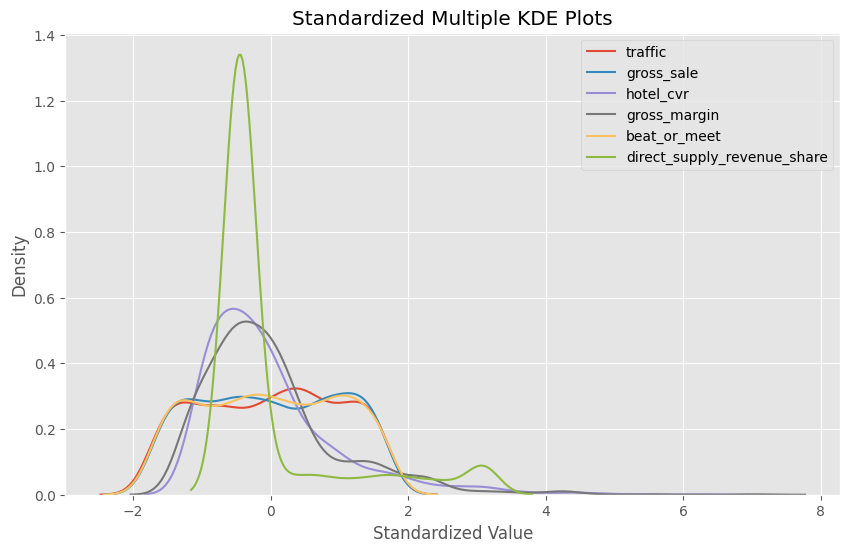

In [ ]:
scaler = StandardScaler()
# 正確選取多個列的方式
columns_to_scale = ['traffic', 'gross_sale', 'hotel_cvr', 'gross_margin', 'beat_or_meet', 'direct_supply_revenue_share']
df_standardized = pd.DataFrame(scaler.fit_transform(sorted_df[columns_to_scale]), columns=columns_to_scale)

# 創建一個圖形對象
plt.figure(figsize=(10, 6))

# 繪製標準化後的 KDE 曲線
for column in df_standardized.columns:
    sns.kdeplot(df_standardized[column], label=column)

# data1 = np.random.normal(loc=0, scale=1, size=1000000)
# sns.kdeplot(data1, label='Normal Distribution', fill=True)

# 添加標題和標籤
plt.title('Standardized Multiple KDE Plots')
plt.xlabel('Standardized Value')
plt.ylabel('Density')

# 顯示圖例
plt.legend()

# 顯示圖形
plt.show()

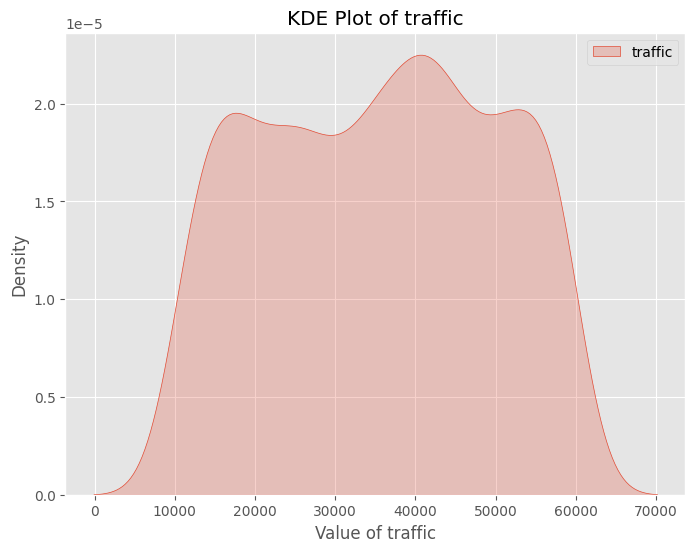

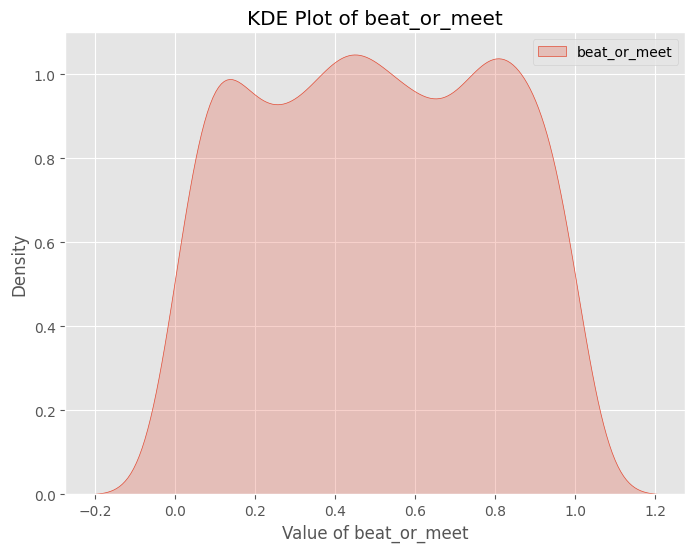

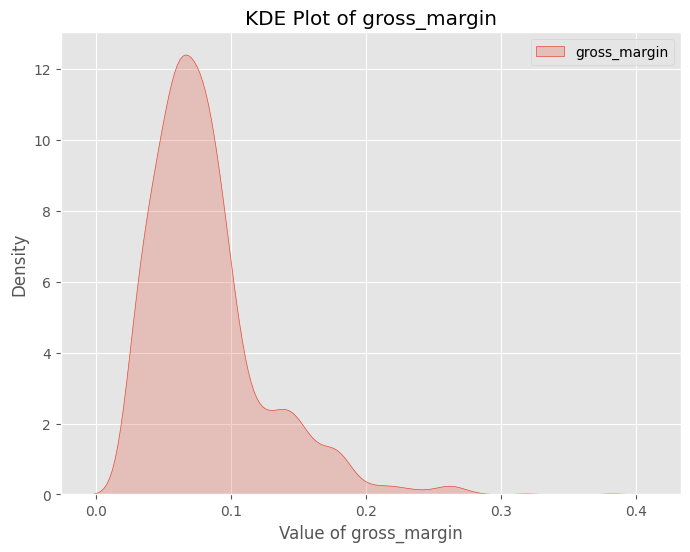

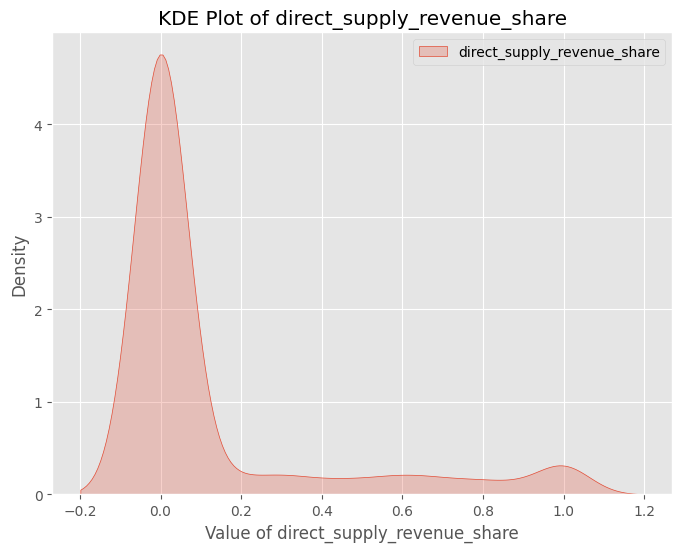

In [ ]:
target_column = ['traffic', 'beat_or_meet', 'gross_margin', 'direct_supply_revenue_share']

for i in target_column:
  data = sorted_df[i]

  plt.figure(figsize=(8, 6))
  sns.kdeplot(data, label=i, shade=True)

  plt.title(f'KDE Plot of {i}')
  plt.xlabel(f'Value of {i}')
  plt.ylabel('Density')
  plt.legend()
  plt.show()

### Overall Pairplot

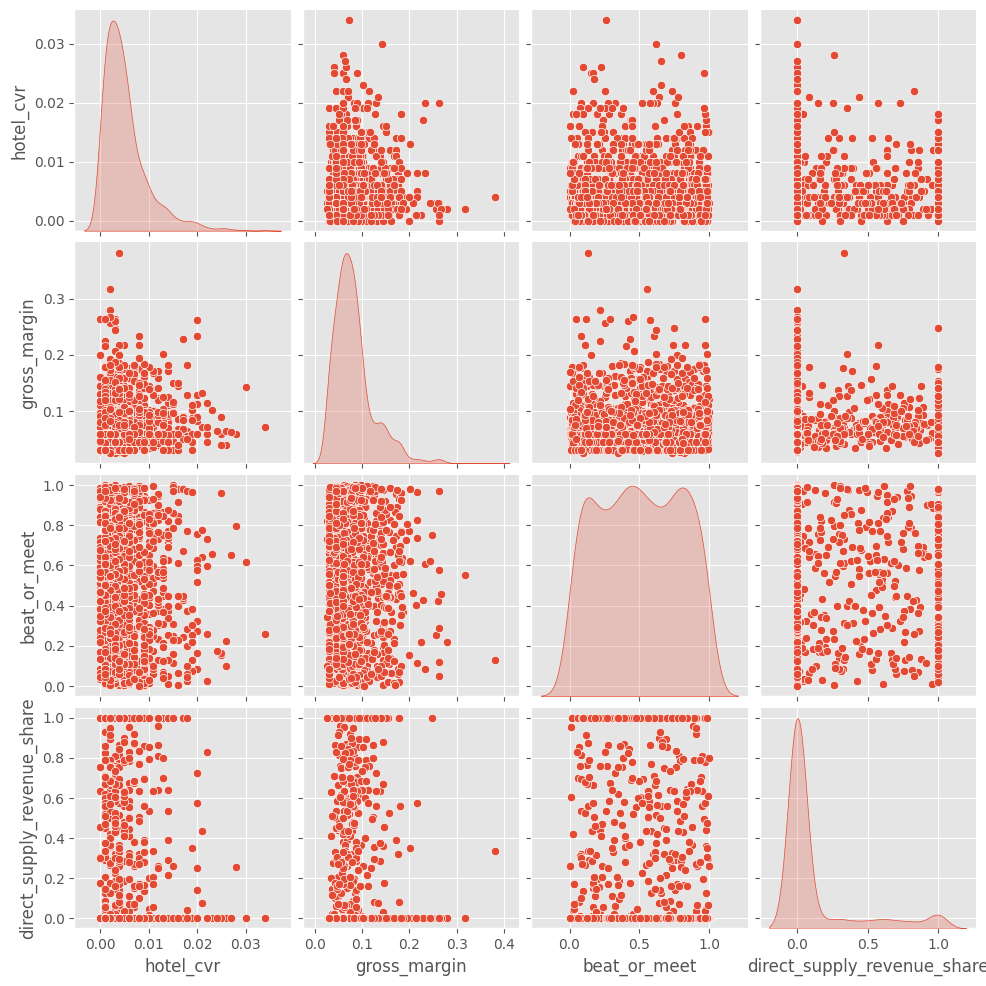

In [ ]:
sns.pairplot(sorted_df[['hotel_cvr', 'gross_margin', 'beat_or_meet', 'direct_supply_revenue_share']],
            #  hue = 'lv2_district',
             kind = 'scatter',
             diag_kind = 'kde',
            #  palette='Set2',
            #  markers=['o', 's', 'D'],
            #  plot_kws={'alpha': 0.7},
             diag_kws = {'shade': True},
             height = 2.5,
             aspect = 1)

#### Pairplot by Region

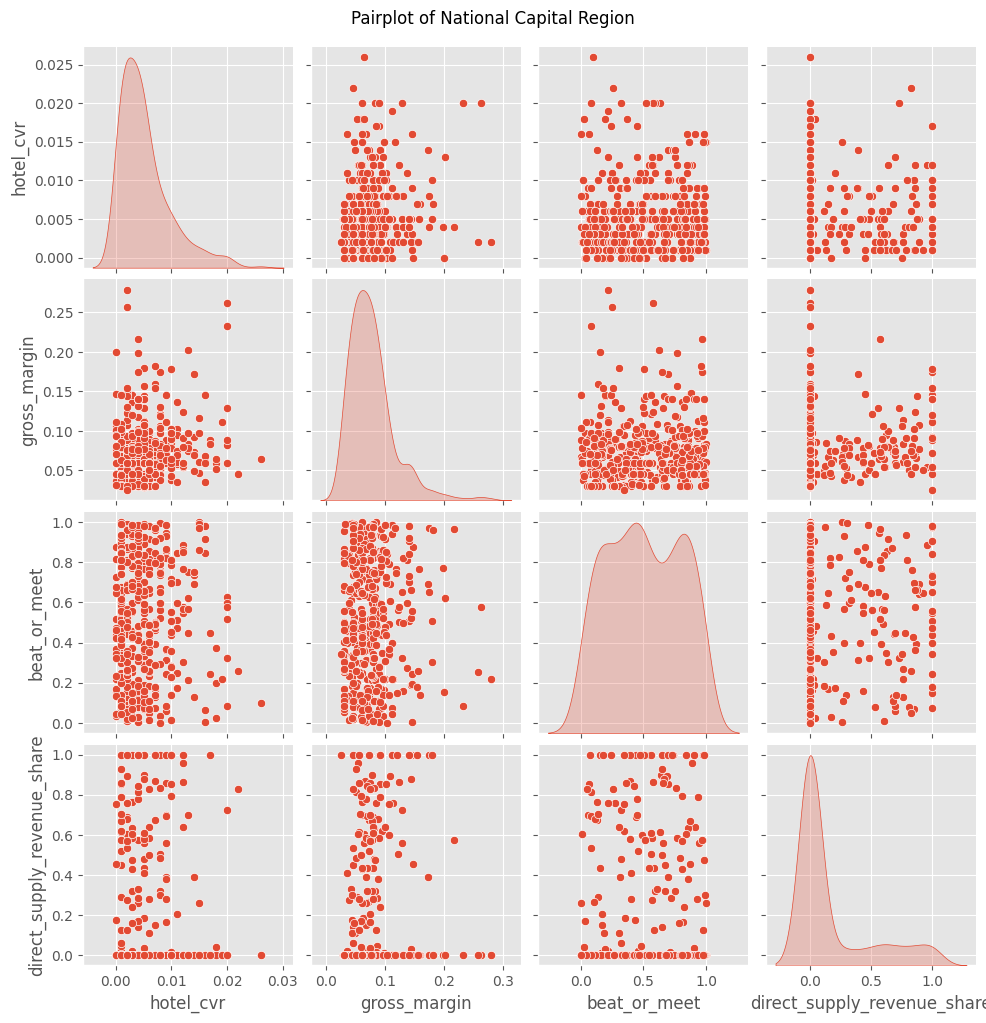

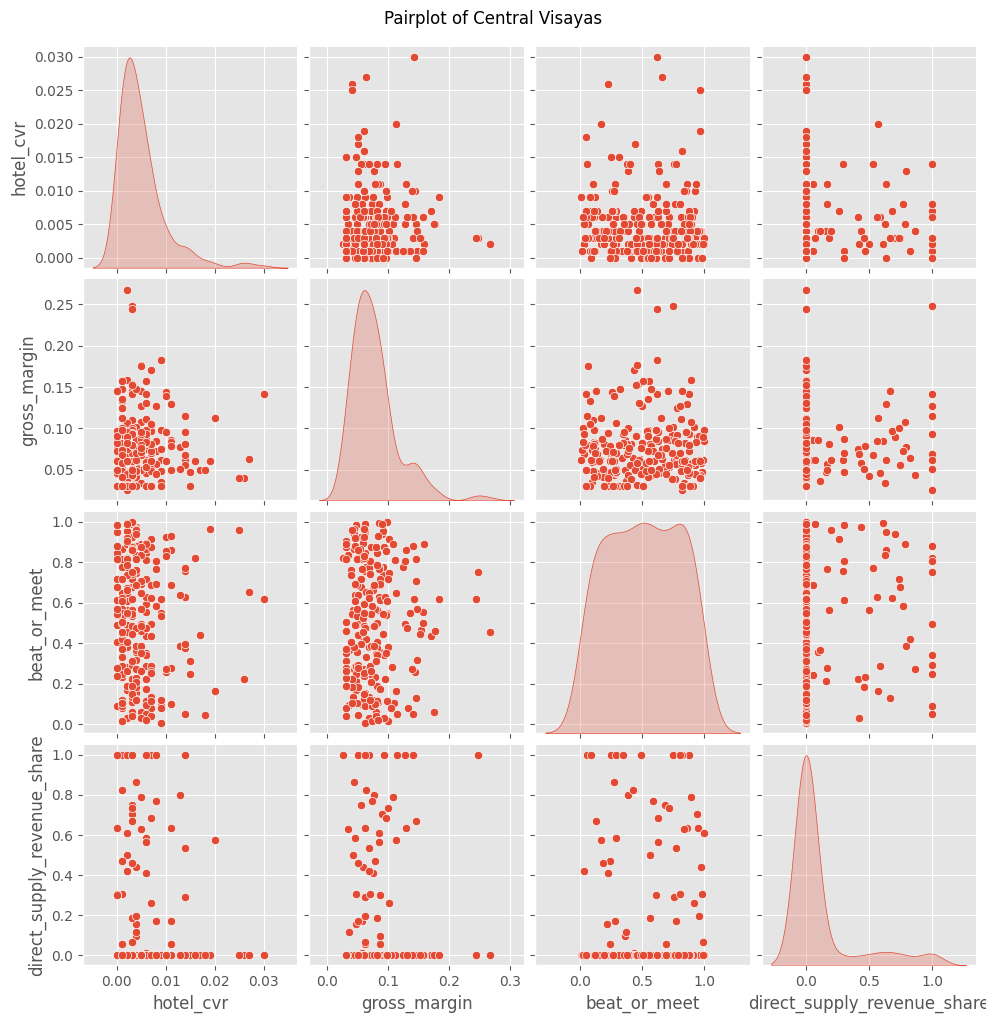

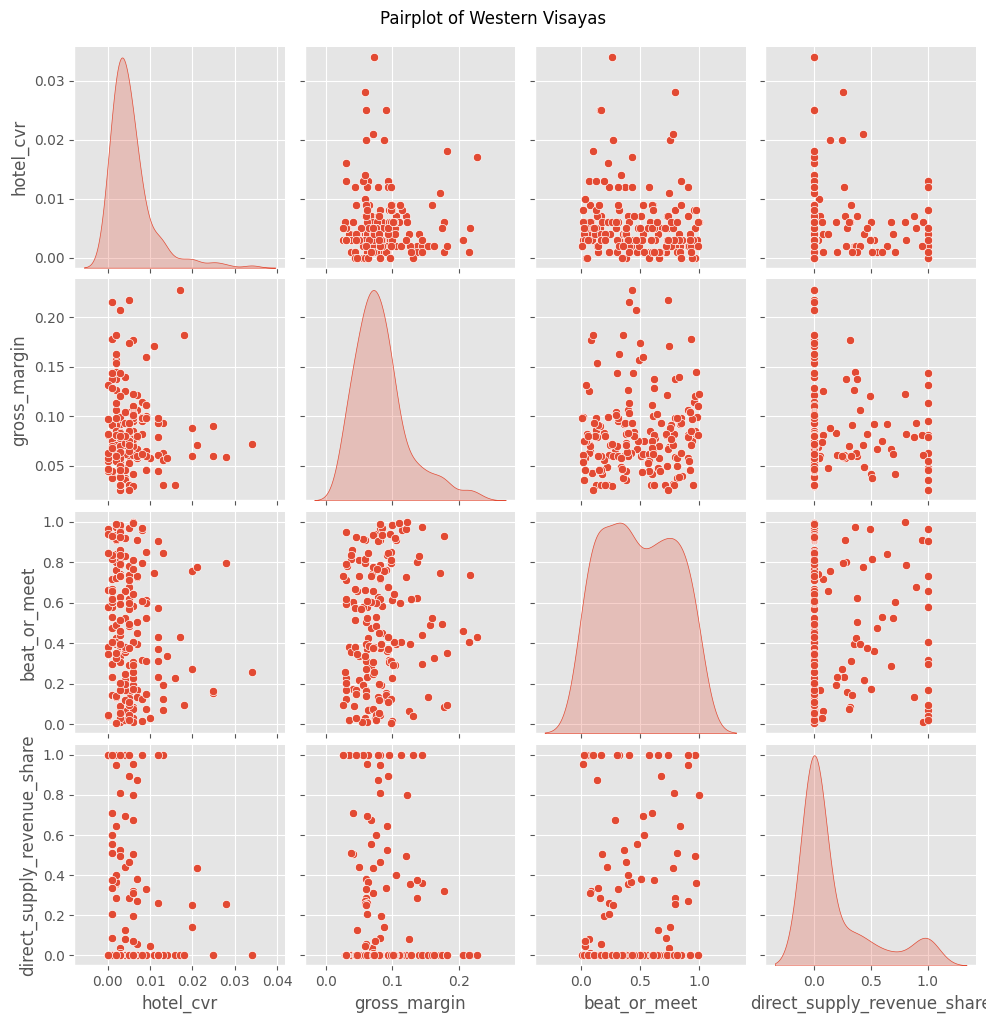

In [ ]:
district_list = sorted_df['region'].unique()
district_list = ['National Capital Region', 'Central Visayas', 'Western Visayas']


for i in district_list:
    temp_df = sorted_df.loc[sorted_df['region'] == i]

    g = sns.pairplot(
        temp_df[['hotel_cvr', 'gross_margin', 'beat_or_meet', 'direct_supply_revenue_share']],
        kind='scatter',
        diag_kind='kde',
        diag_kws={'shade': True},
        height=2.5,
        aspect=1
    )
    g.fig.suptitle(f'Pairplot of {i}', y=1.02)
    g.fig.set_dpi(100)
    plt.show()

## K-means Cluster

### Elbow Method

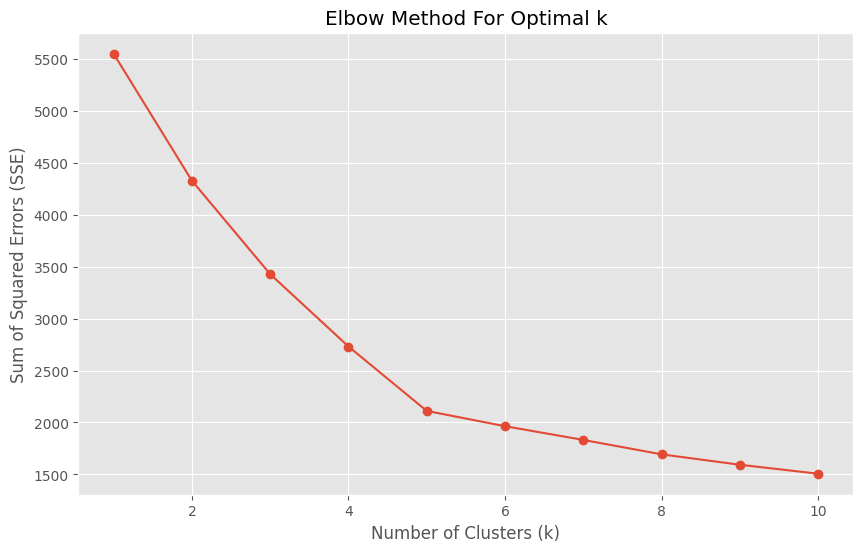

In [ ]:
# Step 1: Load dataset
klook_data = sorted_df.copy()

# Step 2: Select clustering variables and handle missing values
selected_columns = ['gross_margin', 'hotel_cvr', 'beat_or_meet', 'direct_supply_revenue_share']
klook_data_selected = klook_data[selected_columns]
klook_data_selected.fillna(klook_data_selected.mean(), inplace=True)

# Step 3: Standardize the data
scaler = StandardScaler()
klook_data_scaled = scaler.fit_transform(klook_data_selected)

# Step 4: Use Elbow Method to find the optimal number of clusters
sse = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(klook_data_scaled)
    sse.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(10, 6), dpi=100)
plt.plot(k_values, sse, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()

### Decide Optimal K

In [ ]:
# Step 5: Perform KMeans Clustering with 5 clusters (as determined by Elbow Method)
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
klook_data['cluster'] = kmeans.fit_predict(klook_data_scaled)
klook_data['cluster'] = klook_data['cluster'].apply(lambda x: x+1)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


### Dimension Deduction

In [ ]:
# Step 6: Use PCA for dimensionality reduction and visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(klook_data_scaled)

# Add PCA result to DataFrame
klook_data['PCA1'] = pca_result[:, 0]
klook_data['PCA2'] = pca_result[:, 1]

#### **[in case]** Import Labeled Data

In [ ]:
klook_data = pd.read_csv('/content/drive/MyDrive/export_result_klook_casestudy_data.csv')

### Plot the Clusters

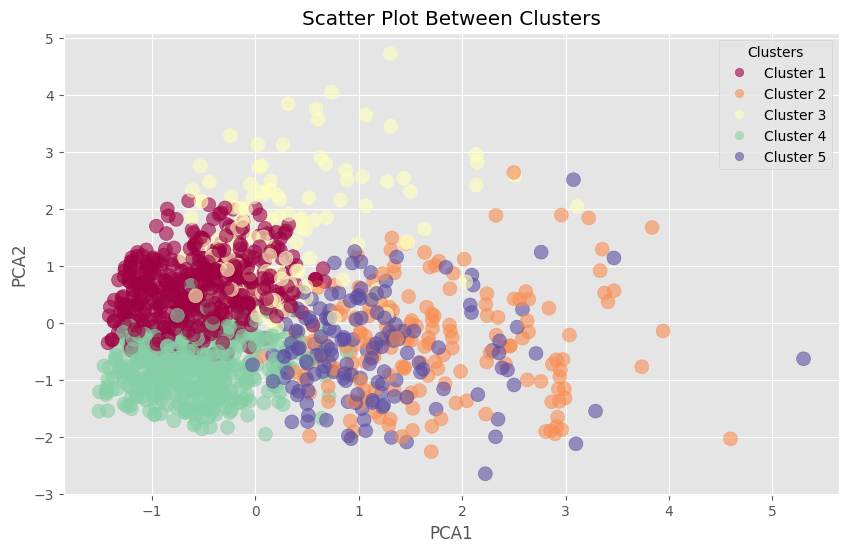

In [ ]:
# low_saturation_colors = ['#A6CEE3', '#1F78B4', '#CAB2D6', '#33A02C', '#FB9A99']
# cmap = ListedColormap(low_saturation_colors)

plt.figure(figsize=(10, 6), dpi=100)

scatter = plt.scatter(klook_data['PCA1'], klook_data['PCA2'], c=klook_data['cluster'], cmap='Spectral', marker='o', s=100, alpha = 0.6)

handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
legend_labels = [f"Cluster {int(label)}" for label in np.unique(klook_data['cluster'])]
plt.legend(handles, legend_labels, title="Clusters", loc="upper right")

plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Scatter Plot Between Clusters')
plt.grid(True)

# 顯示圖表
plt.show()

### Stat of each Clusters

In [ ]:
cluster_means_filtered = klook_data.groupby('cluster')[['traffic', 'gross_sale', 'gross_margin', 'hotel_cvr', 'beat_or_meet', 'direct_supply_revenue_share']].median().reset_index()
city_nunique_filtered = klook_data.groupby('cluster')['city'].nunique().reset_index()
hotel_count_filtered = klook_data.groupby('cluster')['hotel_name'].count().reset_index()

stat_df = pd.merge(cluster_means_filtered, city_nunique_filtered, on='cluster')
stat_df = pd.merge(stat_df, hotel_count_filtered, on='cluster')
stat_df['gross_margin_%'] = stat_df['gross_margin'].apply(lambda x: np.around(x * 100, 3))
stat_df['hotel_cvr_%'] = stat_df['hotel_cvr'].apply(lambda x: np.around(x * 100, 3))
stat_df['beat_or_meet_%'] = stat_df['beat_or_meet'].apply(lambda x: np.around(x * 100, 3))
stat_df['direct_supply_revenue_share_%'] = stat_df['direct_supply_revenue_share'].apply(lambda x: np.around(x * 100, 3))
stat_df[['cluster', 'traffic', 'gross_sale', 'gross_margin_%', 'hotel_cvr_%', 'beat_or_meet_%', 'direct_supply_revenue_share_%', 'city', 'hotel_name']]

,cluster,traffic,gross_sale,gross_margin_%,hotel_cvr_%,beat_or_meet_%,direct_supply_revenue_share_%,city,hotel_name
0,1,38176.5,13501.5,6.4,0.4,24.990,0.0,71,490
1,2,36235.0,15291.0,8.1,0.4,52.480,82.4,23,175
2,3,15743.0,25310.5,6.8,1.4,52.705,0.0,44,134
3,4,39085.0,12824.0,6.8,0.3,78.540,0.0,60,439
4,5,39184.0,13500.5,16.0,0.3,50.170,0.0,50,150


### Plot the Clusters' Metrics

#### A

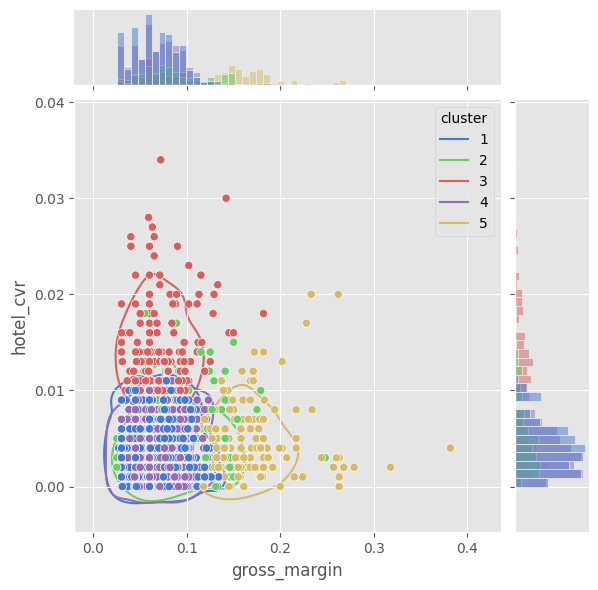

In [ ]:
custom_palette = sns.color_palette("muted6")
g = sns.JointGrid(data=klook_data, x="gross_margin", y="hotel_cvr", hue="cluster", palette=custom_palette)
g.plot(sns.scatterplot, sns.histplot)
g.plot_joint(sns.kdeplot, color="r", zorder=0, levels=2)

#### B

<Figure size 3200x2400 with 0 Axes>

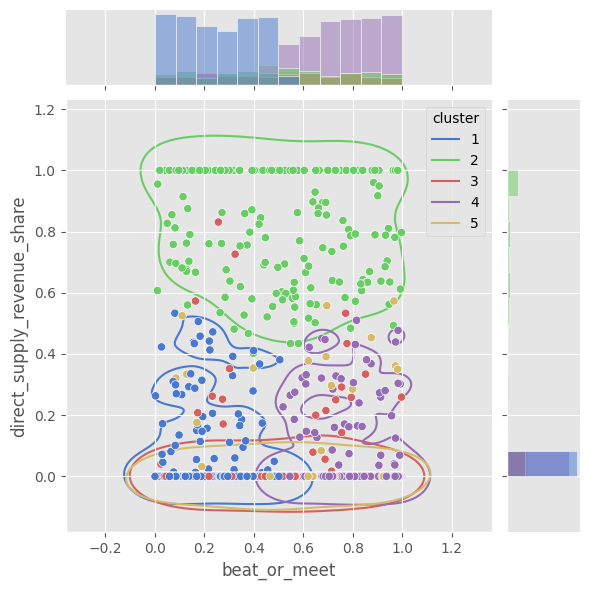

In [ ]:
plt.figure(dpi=500)

custom_palette = sns.color_palette("muted6")
g = sns.JointGrid(data=klook_data, x="beat_or_meet", y="direct_supply_revenue_share", hue="cluster", palette=custom_palette)
g.plot(sns.scatterplot, sns.histplot)
g.plot_joint(sns.kdeplot, zorder=0, levels=2)

<Figure size 3200x2400 with 0 Axes>

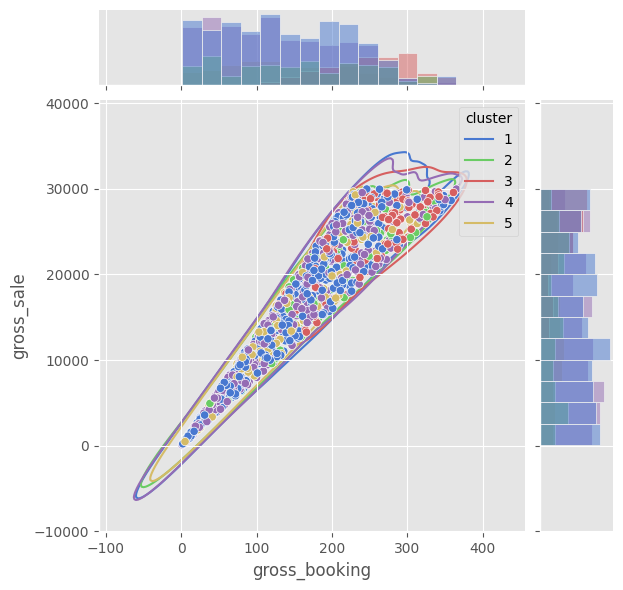

In [ ]:
plt.figure(dpi=500)

custom_palette = sns.color_palette("muted6")
g = sns.JointGrid(data=klook_data, x="gross_booking", y="gross_sale", hue="cluster", palette=custom_palette)
g.plot(sns.scatterplot, sns.histplot)
g.plot_joint(sns.kdeplot, zorder=0, levels=2)

In [ ]:
cluster_means_filtered = klook_data.groupby('cluster').agg(
    gross_margin_mean=('gross_margin', 'mean'),
    gross_margin_median=('gross_margin', 'median'),
    hotel_cvr_mean=('hotel_cvr', 'mean'),
    hotel_cvr_median=('hotel_cvr', 'median'),
    beat_or_meet_mean=('beat_or_meet', 'mean'),
    beat_or_meet_median=('beat_or_meet', 'median'),
    direct_supply_revenue_share_mean=('direct_supply_revenue_share', 'mean'),
    direct_supply_revenue_share_median=('direct_supply_revenue_share', 'median'),
    hotel_name_count=('city', 'nunique')
)

cluster_means_filtered

,gross_margin_mean,gross_margin_median,hotel_cvr_mean,hotel_cvr_median,beat_or_meet_mean,beat_or_meet_median,direct_supply_revenue_share_mean,direct_supply_revenue_share_median,hotel_name_count
cluster,,,,,,,,,
1,0.066024,0.064,0.004027,0.004,0.253081,0.24990,0.024573,0.000,71
2,0.088057,0.081,0.004943,0.004,0.507586,0.52480,0.808823,0.824,23
3,0.074306,0.068,0.015463,0.014,0.499111,0.52705,0.048396,0.000,44
4,0.068239,0.068,0.003740,0.003,0.775380,0.78540,0.025490,0.000,60
5,0.170680,0.160,0.004380,0.003,0.511125,0.50170,0.036480,0.000,50


### Check for Top-K Cities/Hotels

In [ ]:
stat_df = klook_data.groupby(['cluster', 'city'])['hotel_name'].count().to_frame('hotel_count').sort_values(by = 'hotel_count', ascending = False).reset_index()
stat_df

,cluster,city,hotel_count
0,1,Metro Manila,144
1,4,Metro Manila,113
2,2,Metro Manila,73
3,4,Cebu,54
4,1,Cebu,53
...,...,...,...
243,2,Bongabon,1
244,2,Carles,1
245,2,Conception,1
246,2,Dingalan,1


In [ ]:
klook_data['city'].nunique()

110

In [ ]:
city_totals = stat_df.groupby('city')['hotel_count'].sum()

city_cluster_totals = stat_df.groupby(['city', 'cluster'])['hotel_count'].sum().unstack(fill_value=0)

city_cluster_proportions = city_cluster_totals.divide(city_totals, axis=0)
city_cluster_proportions

cluster,1,2,3,4,5
city,,,,,
Angeles,0.300000,0.1,0.200000,0.300000,0.100000
Antipolo,1.000000,0.0,0.000000,0.000000,0.000000
Bacolod,0.375000,0.0,0.062500,0.562500,0.000000
Bacolor,0.000000,0.0,0.500000,0.000000,0.500000
Bacoor City,0.500000,0.0,0.000000,0.000000,0.500000
...,...,...,...,...,...
Urdaneta,0.000000,0.0,0.000000,0.500000,0.500000
Valencia,0.333333,0.0,0.333333,0.000000,0.333333
Vigan,0.416667,0.0,0.083333,0.333333,0.166667


In [ ]:
city_cluster_totals

cluster,1,2,3,4,5
city,,,,,
Angeles,6,2,4,6,2
Antipolo,1,0,0,0,0
Bacolod,6,0,1,9,0
Bacolor,0,0,1,0,1
Bacoor City,1,0,0,0,1
...,...,...,...,...,...
Urdaneta,0,0,0,1,1
Valencia,1,0,1,0,1
Vigan,5,0,1,4,2


In [ ]:
target_cluster = 1

In [ ]:
klook_data.loc[klook_data['cluster'] == target_cluster].sort_values(by = ['gross_margin',
                                                                          'beat_or_meet'])[['city',
                                                                                            'hotel_name',
                                                                                            'cluster',
                                                                                            'gross_sale',
                                                                                            'gross_booking',
                                                                                            'traffic',
                                                                                            'gross_margin',
                                                                                            'hotel_cvr',
                                                                                            'beat_or_meet',
                                                                                            'direct_supply_revenue_share']].reset_index(drop = True).head(15)

,city,hotel_name,cluster,gross_sale,gross_booking,traffic,gross_margin,hotel_cvr,beat_or_meet,direct_supply_revenue_share
0,Palawan,Just Inn,1,25603,202,57115,0.027,0.004,0.1002,0.0
1,Ormoc,Copenhagen Residences,1,12810,102,11788,0.029,0.009,0.0336,0.0
2,Iloilo City,RedDoorz @ San Jose Tagbak Jaro Iloilo,1,12746,157,25524,0.029,0.006,0.2602,0.0
3,Metro Manila,Citizen Hotel,1,23366,188,38105,0.029,0.005,0.3324,0.0
4,Bacoor City,Fynn Boutique Hotel,1,21937,226,51935,0.029,0.004,0.5190,0.0
5,Cebu,Mabolo Royal Hotel,1,19008,207,29296,0.030,0.007,0.0409,0.0
6,Metro Manila,Rooms R Us,1,11483,105,46133,0.030,0.002,0.0534,0.0
7,Santa Rosa,Madie's Place,1,12273,144,37195,0.030,0.004,0.0585,0.0
8,Metro Manila,Herald Suites,1,9250,76,28963,0.030,0.003,0.0675,0.0
9,Baguio,La Brea Inn,1,17029,172,56679,0.030,0.003,0.0678,0.0


In [ ]:
target_cluster = 2

In [ ]:
klook_data.loc[klook_data['cluster'] == target_cluster].sort_values(by = ['gross_margin',
                                                                          'hotel_cvr',
                                                                          'beat_or_meet'])[['city',
                                                                                            'hotel_name',
                                                                                            'cluster',
                                                                                            'gross_sale',
                                                                                            'gross_booking',
                                                                                            'traffic',
                                                                                            'gross_margin',
                                                                                            'hotel_cvr',
                                                                                            'beat_or_meet',
                                                                                            'direct_supply_revenue_share']].reset_index(drop = True).head(15)

,city,hotel_name,cluster,gross_sale,gross_booking,traffic,gross_margin,hotel_cvr,beat_or_meet,direct_supply_revenue_share
0,Metro Manila,The Chipper Hotel,2,4950,38,23551,0.025,0.002,0.3435,1.000
1,Cebu,Tsai Hotel and Residences,2,3109,30,17009,0.025,0.002,0.8196,1.000
2,Boracay,"The Ferra Premier by JG, Boracay",2,15888,143,55067,0.025,0.003,0.7335,1.000
3,Boracay,One Crescent Place,2,24762,278,56401,0.025,0.005,0.0973,1.000
4,Cebu,Maayo Hotel,2,22952,261,57636,0.034,0.005,0.8328,0.629
5,Boracay,Boracay Mandarin Island Hotel,2,26219,243,59668,0.035,0.004,0.0205,1.000
6,Iloilo City,Richmonde Hotel Iloilo,2,1076,9,10134,0.041,0.001,0.6037,0.712
7,Bohol,Solea Coast Resort Panglao,2,8236,78,45198,0.042,0.002,0.5631,0.500
8,Cebu,Hop Inn Hotel Cebu City,2,25738,243,57787,0.043,0.004,0.2721,0.862
9,Unknown,Nature's Village Resort,2,4269,43,47024,0.045,0.001,0.8434,1.000


In [ ]:
target_cluster = 3

In [ ]:
klook_data.loc[klook_data['cluster'] == target_cluster].sort_values(by = 'hotel_cvr', ascending = False)[['city',
                                                                                            'hotel_name',
                                                                                            'cluster',
                                                                                            'gross_sale',
                                                                                            'gross_booking',
                                                                                            'traffic',
                                                                                            'gross_margin',
                                                                                            'hotel_cvr',
                                                                                            'beat_or_meet',
                                                                                            'direct_supply_revenue_share']].reset_index(drop = True).head(15)

,city,hotel_name,cluster,gross_sale,gross_booking,traffic,gross_margin,hotel_cvr,beat_or_meet,direct_supply_revenue_share
0,Cebu,Matutinao Beach,1,27899,266,24083,0.078,0.011,0.1000,0.000
1,Tagaytay,Hotel Monticello,1,13577,112,10674,0.047,0.011,0.0835,0.000
2,Davao,Go Hotels Lanang Davao,1,11989,111,10200,0.075,0.011,0.0606,0.000
3,Metro Manila,Lancaster Hotel Manila,1,24356,262,27356,0.097,0.010,0.1388,0.000
4,Davao,GV Hotel Davao,1,24893,233,23148,0.045,0.010,0.2957,0.000
5,Naga,Robertson Hotel,1,15121,161,16298,0.083,0.010,0.2578,0.000
6,Tagaytay,Casa La Silvinas Hotel and Event Resort,1,27980,345,34837,0.069,0.010,0.1825,0.000
7,Vigan,Villa Angela Heritage House,1,29387,283,28974,0.085,0.010,0.1259,0.000
8,Metro Manila,The Excelsior Hotel,1,23413,289,29808,0.090,0.010,0.2817,0.000
9,San Isidro,Trogon's Perch,1,21287,190,19988,0.060,0.010,0.0279,0.000


In [ ]:
target_cluster = 4

In [ ]:
klook_data.loc[klook_data['cluster'] == target_cluster].sort_values(by = ['gross_margin',
                                                                          'hotel_cvr',
                                                                          'beat_or_meet'])[['city',
                                                                                            'hotel_name',
                                                                                            'cluster',
                                                                                            'gross_sale',
                                                                                            'gross_booking',
                                                                                            'traffic',
                                                                                            'gross_margin',
                                                                                            'hotel_cvr',
                                                                                            'beat_or_meet',
                                                                                            'direct_supply_revenue_share']].reset_index(drop = True).head(15)

,city,hotel_name,cluster,gross_sale,gross_booking,traffic,gross_margin,hotel_cvr,beat_or_meet,direct_supply_revenue_share
0,Angeles,Hevea Hotel & Resort,4,12824,103,21253,0.028,0.005,0.7876,0.0
1,Palawan,Outpost Beach Hostel,4,617,5,33489,0.029,0.000,0.8099,0.0
2,Calamba,Hotel Marciano,4,437,4,42910,0.030,0.000,0.6265,0.0
3,Tagaytay,Vianshe Hotel Tagaytay,4,1030,10,41536,0.030,0.000,0.9424,0.0
4,Samal Island,La Vida Hostel,4,2945,26,28804,0.030,0.001,0.6944,0.0
5,Davao,Hotel Midori Davao,4,7143,88,59098,0.030,0.001,0.7762,0.0
6,Angeles,Maharajah Hotel,4,3921,47,39599,0.030,0.001,0.8279,0.0
7,Metro Manila,Capital O 907 Ceo Flats,4,4199,37,40965,0.030,0.001,0.8466,0.0
8,Metro Manila,OYO 190 Anglo Residences,4,7186,57,40912,0.030,0.001,0.8673,0.0
9,Urdaneta,Levo Hotel,4,4862,43,59414,0.030,0.001,0.8818,0.0


In [ ]:
target_cluster = 5

In [ ]:
klook_data.loc[klook_data['cluster'] == target_cluster].sort_values(by = ['gross_margin',
                                                                          'hotel_cvr',
                                                                          'beat_or_meet'])[['city',
                                                                                            'hotel_name',
                                                                                            'cluster',
                                                                                            'gross_sale',
                                                                                            'gross_booking',
                                                                                            'traffic',
                                                                                            'gross_margin',
                                                                                            'hotel_cvr',
                                                                                            'beat_or_meet',
                                                                                            'direct_supply_revenue_share']].reset_index(drop = True).head(15)

,city,hotel_name,cluster,gross_sale,gross_booking,traffic,gross_margin,hotel_cvr,beat_or_meet,direct_supply_revenue_share
0,Angeles,Hevea Hotel & Resort,4,12824,103,21253,0.028,0.005,0.7876,0.0
1,Palawan,Outpost Beach Hostel,4,617,5,33489,0.029,0.000,0.8099,0.0
2,Calamba,Hotel Marciano,4,437,4,42910,0.030,0.000,0.6265,0.0
3,Tagaytay,Vianshe Hotel Tagaytay,4,1030,10,41536,0.030,0.000,0.9424,0.0
4,Samal Island,La Vida Hostel,4,2945,26,28804,0.030,0.001,0.6944,0.0
5,Davao,Hotel Midori Davao,4,7143,88,59098,0.030,0.001,0.7762,0.0
6,Angeles,Maharajah Hotel,4,3921,47,39599,0.030,0.001,0.8279,0.0
7,Metro Manila,Capital O 907 Ceo Flats,4,4199,37,40965,0.030,0.001,0.8466,0.0
8,Metro Manila,OYO 190 Anglo Residences,4,7186,57,40912,0.030,0.001,0.8673,0.0
9,Urdaneta,Levo Hotel,4,4862,43,59414,0.030,0.001,0.8818,0.0


In [ ]:
klook_data.to_csv('export_result_klook_casestudy_data.csv', index = False)

In [ ]:
stat_df = sorted_df.groupby('city')['hotel_name'].count().reset_index().sort_values(by = 'hotel_name', ascending = False).reset_index(drop = True)
stat_df

,city,hotel_name
0,Metro Manila,400
1,Cebu,157
2,Boracay,106
3,Palawan,65
4,Bohol,65
...,...,...
105,Basco,1
106,Opol,1
107,Ozamiz,1
108,Baliuag,1


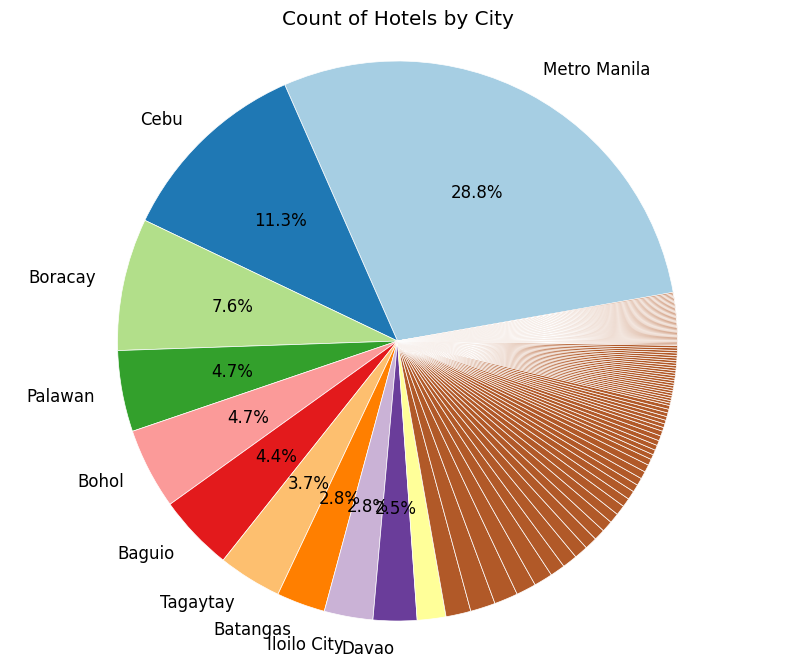

In [ ]:
city_counts = sorted_df.groupby('city')['hotel_name'].count().reset_index().sort_values(by = 'hotel_name').reset_index(drop = True)
city_counts = city_counts.groupby('city')['hotel_name'].sum()

total = city_counts.sum()
percentages = city_counts / total * 100

sorted_data = pd.DataFrame({'city': city_counts.index, 'percentages': percentages}).sort_values(by='percentages', ascending=False)

sorted_city_counts = city_counts[sorted_data['city']]
sorted_percentages = sorted_data['percentages']

colors = plt.cm.Paired(range(len(sorted_city_counts)))

def autopct_format(pct):
    return f'{pct:.1f}%' if pct > 2.5 else ''

labels = [f'{city}' if pct > 2.5 else '' for city, pct in zip(sorted_city_counts.index, sorted_percentages)]

plt.figure(figsize=(10, 8))
plt.pie(
    sorted_city_counts,
    labels=labels,
    colors=colors,
    autopct=autopct_format,
    startangle=10,
    textprops={'fontsize': 12},
    wedgeprops={'edgecolor': 'white'}
)

plt.title('Count of Hotels by City')
plt.axis('equal')
plt.show()

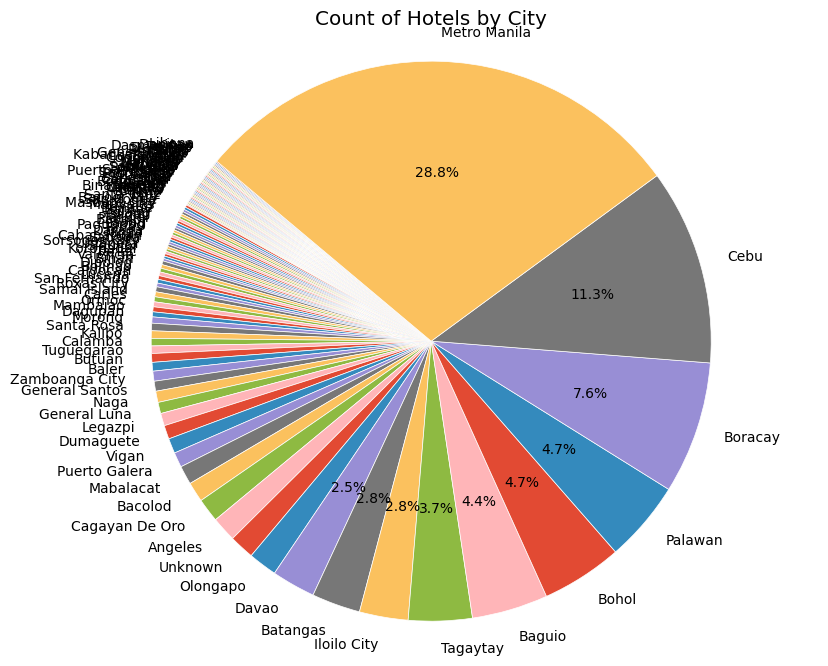

In [ ]:
# colors = plt.cm.Paired(range(len(city_counts)))

def autopct_format(pct):
    return f'{pct:.1f}%' if pct > 2.5 else ''

labels = [f'{city}' if pct > 2.5 else '' for city, pct in zip(city_counts.index, percentages)]

plt.figure(figsize=(10, 8))
plt.pie(
    city_counts['hotel_name'],
    labels = city_counts['city'],
    # colors = colors,
    autopct = autopct_format,
    startangle = 140,
    textprops = {'fontsize': 10},
    wedgeprops = {'edgecolor': 'white'}
)

plt.title('Count of Hotels by City')
plt.axis('equal')
plt.show()

<Figure size 1200x600 with 0 Axes>

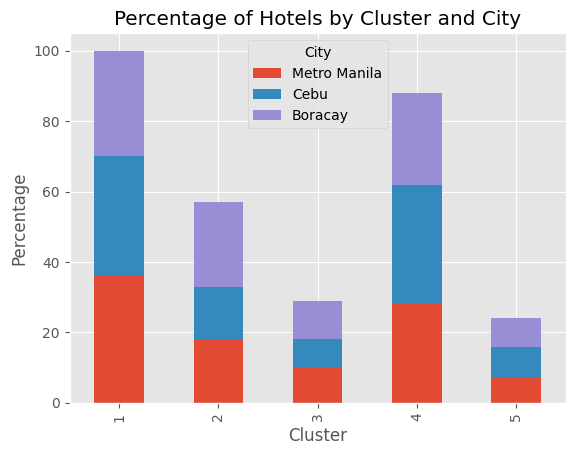

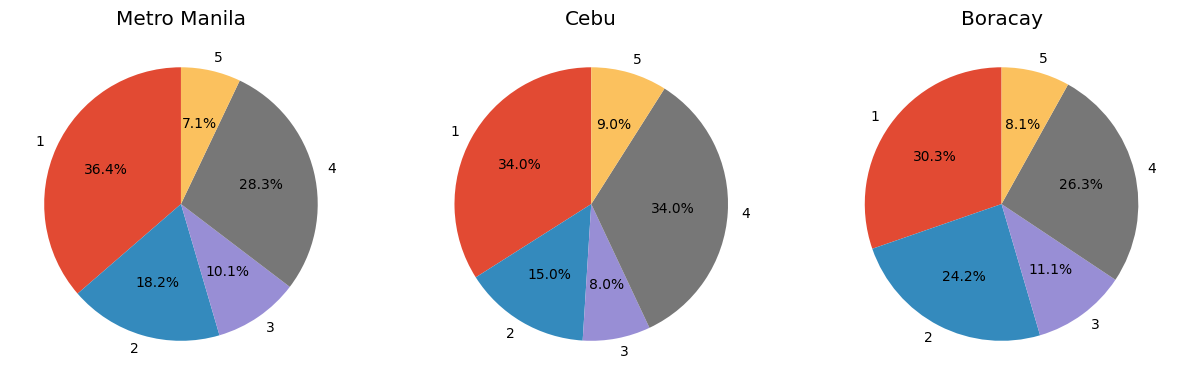

In [ ]:
# 建立 DataFrame
data = {
    'Metro Manila': [36, 18, 10, 28, 7],
    'Cebu': [34, 15, 8, 34, 9],
    'Boracay': [30, 24, 11, 26, 8]
}
clusters = [1, 2, 3, 4, 5]
df = pd.DataFrame(data, index=clusters)

# 繪製直方佔比圖
plt.figure(figsize=(12, 6))
df.plot(kind='bar', stacked=True)
plt.title('Percentage of Hotels by Cluster and City')
plt.xlabel('Cluster')
plt.ylabel('Percentage')
plt.legend(title='City')
plt.show()

# 繪製圓餅圖
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, city in enumerate(df.columns):
    axs[i].pie(df[city], labels=clusters, autopct='%1.1f%%', startangle=90)
    axs[i].set_title(city)

plt.show()

In [ ]:
city_cluster_proportions = city_cluster_proportions.reset_index(drop = True)
city_cluster_proportions

cluster,city,1,2,3,4,5
0,Angeles,0.300000,0.1,0.200000,0.300000,0.100000
1,Antipolo,1.000000,0.0,0.000000,0.000000,0.000000
2,Bacolod,0.375000,0.0,0.062500,0.562500,0.000000
3,Bacolor,0.000000,0.0,0.500000,0.000000,0.500000
4,Bacoor City,0.500000,0.0,0.000000,0.000000,0.500000
...,...,...,...,...,...,...
105,Urdaneta,0.000000,0.0,0.000000,0.500000,0.500000
106,Valencia,0.333333,0.0,0.333333,0.000000,0.333333
107,Vigan,0.416667,0.0,0.083333,0.333333,0.166667
108,Virac,0.000000,1.0,0.000000,0.000000,0.000000


In [ ]:
city_cluster_proportions['city_mapped'] = city_cluster_proportions['city'].apply(lambda x: x.replace('City', ''))

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import random
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

gdf = gpd.read_file('/content/drive/MyDrive/Municities.shp.shp')
# gdf['traffic'] = [random.uniform(1, 10) for _ in range(len(gdf))]

In [ ]:
# 繪製地圖
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(column='traffic', cmap='OrRd', legend=True, ax=ax, edgecolor='black')

ax.set_title('Philippines Map', fontsize=15)
plt.show()

In [ ]:
set(gdf['name'].unique()).intersection(set(city_cluster_proportions['city_mapped'].unique()))

{'Bacolod',
 'Bacolor',
 'Bagac',
 'Baler',
 'Banaue',
 'Bantay',
 'Basco',
 'Bauang',
 'Binangonan',
 'Bolinao',
 'Bongabon',
 'Burgos',
 'Cainta',
 'Calamba',
 'Calasiao',
 'Carles',
 'Catarman',
 'Cavinti',
 'Daraga',
 'Dingalan',
 'General Luna',
 'Kalibo',
 'La Trinidad',
 'Libona',
 'Lumban',
 'Mahatao',
 'Mahinog',
 'Mambajao',
 'Mariveles',
 'Morong',
 'Naga',
 'Naic',
 'Opol',
 'Pagudpud',
 'Plaridel',
 'Puerto Galera',
 'Rosario',
 'Sagada',
 'San Fernando',
 'San Isidro',
 'San Mateo',
 'San Pablo',
 'San Roque',
 'Santa Cruz',
 'Santa Rosa',
 'Silang',
 'Siquijor',
 'Subic',
 'Taal',
 'Tanay',
 'Tanza',
 'Tiwi',
 'Valencia',
 'Virac'}

In [ ]:
gdf.loc[gdf['name'].str.contains('Manila')]

,psgc_code,name,corr_code,geo_level,city_class,inc_class,urb_rur,pop_2015,pop_2020,status,adm3_pcode,adm3_en,adm3_alt,adm2_pcode,adm1_pcode,adm0_pcode,shape_len,shape_area,shape_sqkm,geometry
1280,1380600000,City of Manila,133900000.0,City,None,HUC,Special,None,None,None,PH1303901,City of Manila,None,PH13039,PH13,PH,0.600152,0.00352,41.96009,"POLYGON ((120.98508 14.63998, 120.98568 14.639..."


In [ ]:
gdf['name_mapped'] = gdf['name'].apply(lambda x:x.replace('City of ', ''))

In [ ]:
len(set(gdf['name_mapped'].unique()).intersection(set(city_cluster_proportions['city_mapped'].unique())))

88

In [ ]:
gdf.loc[gdf['name_mapped'].str.contains('Manila')]

,psgc_code,name,corr_code,geo_level,city_class,inc_class,urb_rur,pop_2015,pop_2020,status,...,adm3_en,adm3_alt,adm2_pcode,adm1_pcode,adm0_pcode,shape_len,shape_area,shape_sqkm,geometry,name_mapped
1280,1380600000,City of Manila,133900000.0,City,None,HUC,Special,None,None,None,...,City of Manila,None,PH13039,PH13,PH,0.600152,0.00352,41.96009,"POLYGON ((120.98508 14.63998, 120.98568 14.639...",Manila


In [ ]:
city_cluster_proportions.loc[city_cluster_proportions['city_mapped'].str.contains('Manila')]

cluster,city,1,2,3,4,5,city_mapped
65,Metro Manila,0.36,0.1825,0.1025,0.2825,0.0725,Manila


In [ ]:
city_cluster_proportions['city_mapped'] = city_cluster_proportions['city_mapped'].apply(lambda x:x.replace(' Manila', 'Manila'))

In [ ]:
merged_gdf = pd.merge(gdf, city_cluster_proportions, left_on = 'name_mapped', right_on = 'city_mapped', how = 'left')

In [ ]:
merged_gdf[1] = merged_gdf[1].fillna(0)
merged_gdf[2] = merged_gdf[2].fillna(0)
merged_gdf[3] = merged_gdf[3].fillna(0)
merged_gdf[4] = merged_gdf[4].fillna(0)
merged_gdf[5] = merged_gdf[5].fillna(0)

In [ ]:
merged_gdf

,psgc_code,name,corr_code,geo_level,city_class,inc_class,urb_rur,pop_2015,pop_2020,status,...,shape_sqkm,geometry,name_mapped,city,1,2,3,4,5,city_mapped
0,102801000,Adams,12801000.0,Mun,None,None,5th,None,None,None,...,111.143026,"POLYGON ((120.96915 18.51012, 120.95867 18.463...",Adams,NaN,0.0,0.0,0.0,0.0,0.0,NaN
1,102802000,Bacarra,12802000.0,Mun,None,None,3rd,None,None,None,...,55.303195,"POLYGON ((120.66821 18.28705, 120.66441 18.282...",Bacarra,NaN,0.0,0.0,0.0,0.0,0.0,NaN
2,102803000,Badoc,12803000.0,Mun,None,None,3rd,None,None,None,...,80.683970,"POLYGON ((120.47814 17.97717, 120.47816 17.977...",Badoc,NaN,0.0,0.0,0.0,0.0,0.0,NaN
3,102804000,Bangui,12804000.0,Mun,None,None,4th,None,None,None,...,115.059041,"POLYGON ((120.81318 18.53457, 120.81358 18.533...",Bangui,NaN,0.0,0.0,0.0,0.0,0.0,NaN
4,102805000,City of Batac,12805000.0,City,None,CC,5th,None,None,None,...,158.123132,"POLYGON ((120.61242 18.10947, 120.612 18.10679...",Batac,NaN,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1637,1999904000,Midsayap Cluster II,NaN,SGU,None,None,None,None,None,None,...,50.379445,"POLYGON ((124.53774 7.08816, 124.52416 7.05555...",Midsayap Cluster II,NaN,0.0,0.0,0.0,0.0,0.0,NaN
1638,1999905000,Pigcawayan Cluster,NaN,SGU,None,None,None,None,None,None,...,48.560572,"MULTIPOLYGON (((124.40575 7.36321, 124.41316 7...",Pigcawayan Cluster,NaN,0.0,0.0,0.0,0.0,0.0,NaN
1639,1999906000,Pikit Cluster I,NaN,SGU,None,None,None,None,None,None,...,59.337843,"MULTIPOLYGON (((124.70394 7.19775, 124.70387 7...",Pikit Cluster I,NaN,0.0,0.0,0.0,0.0,0.0,NaN
1640,1999907000,Pikit Cluster II,NaN,SGU,None,None,None,None,None,None,...,80.999972,"POLYGON ((124.71662 7.01955, 124.71764 7.01802...",Pikit Cluster II,NaN,0.0,0.0,0.0,0.0,0.0,NaN


<Axes: >

Text(0.5, 1.0, 'Map of Cluster 1')

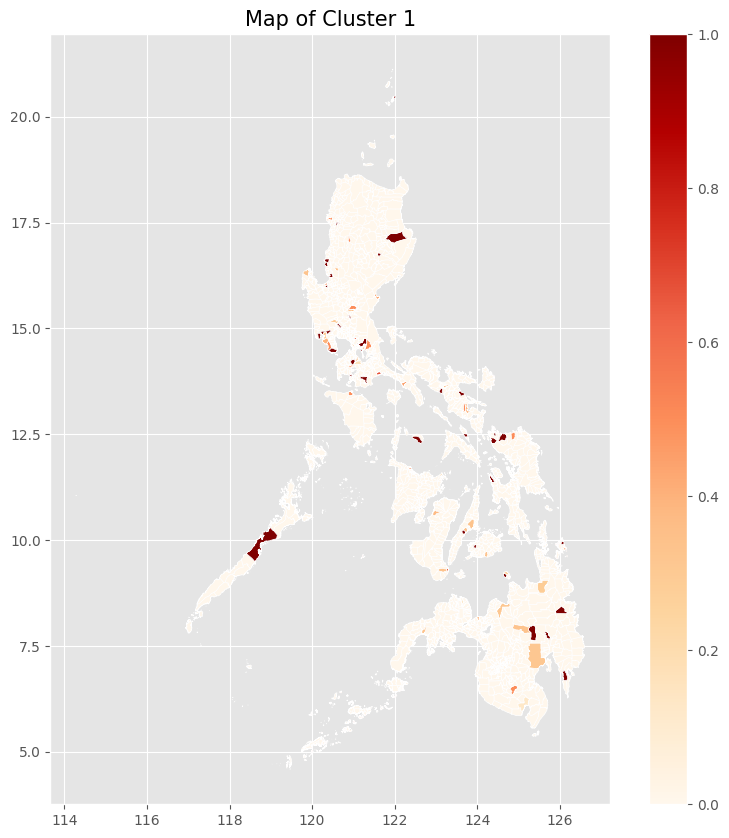

In [ ]:
# 繪製地圖
fig, ax = plt.subplots(figsize=(10, 10))
merged_gdf.plot(column=1, cmap='OrRd', legend=True, ax=ax, edgecolor='white')

ax.set_title('Map of Cluster 1', fontsize=15)
plt.show()

<Axes: >

Text(0.5, 1.0, 'Map of Cluster 2')

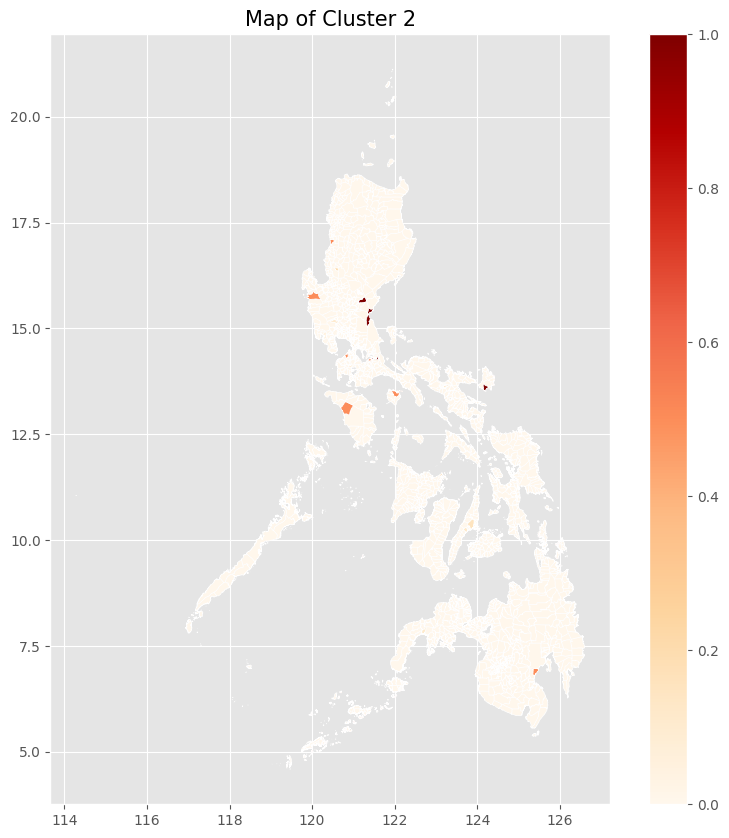

In [ ]:
# 繪製地圖
fig, ax = plt.subplots(figsize=(10, 10))
merged_gdf.plot(column=2, cmap='OrRd', legend=True, ax=ax, edgecolor='white')

ax.set_title('Map of Cluster 2', fontsize=15)
plt.show()

<Axes: >

Text(0.5, 1.0, 'Map of Cluster 3')

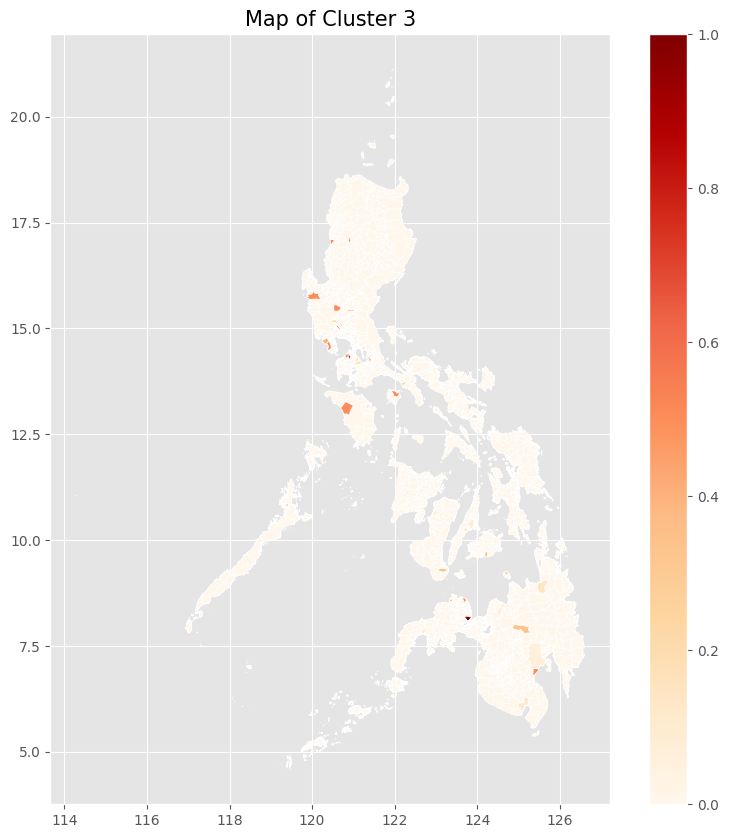

In [ ]:
# 繪製地圖
fig, ax = plt.subplots(figsize=(10, 10))
merged_gdf.plot(column=3, cmap='OrRd', legend=True, ax=ax, edgecolor='white')

ax.set_title('Map of Cluster 3', fontsize=15)
plt.show()

<Axes: >

Text(0.5, 1.0, 'Map of Cluster 4')

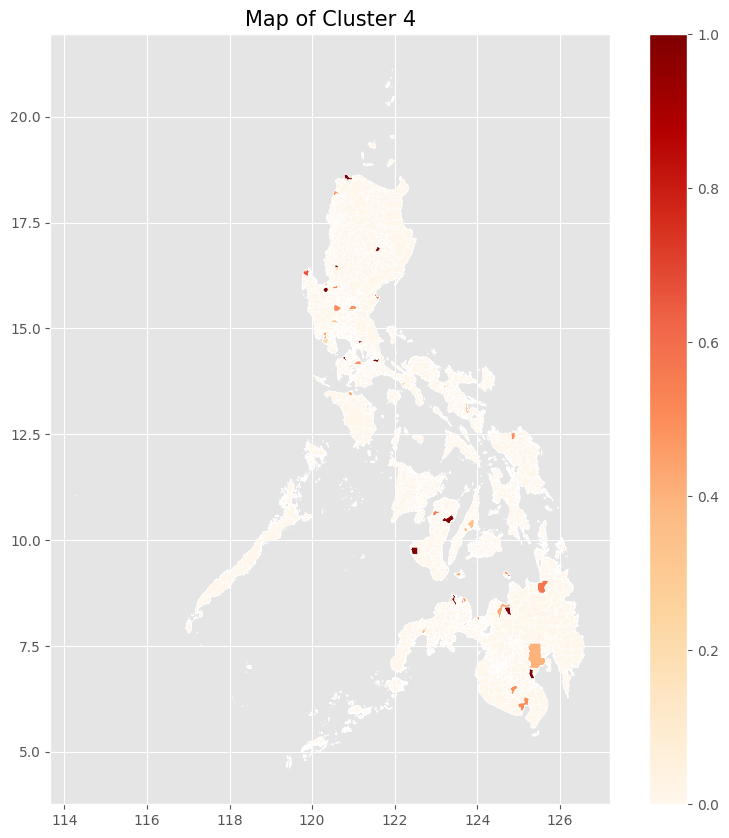

In [ ]:
# 繪製地圖
fig, ax = plt.subplots(figsize=(10, 10))
merged_gdf.plot(column=4, cmap='OrRd', legend=True, ax=ax, edgecolor='white')

ax.set_title('Map of Cluster 4', fontsize=15)
plt.show()

<Axes: >

Text(0.5, 1.0, 'Map of Cluster 5')

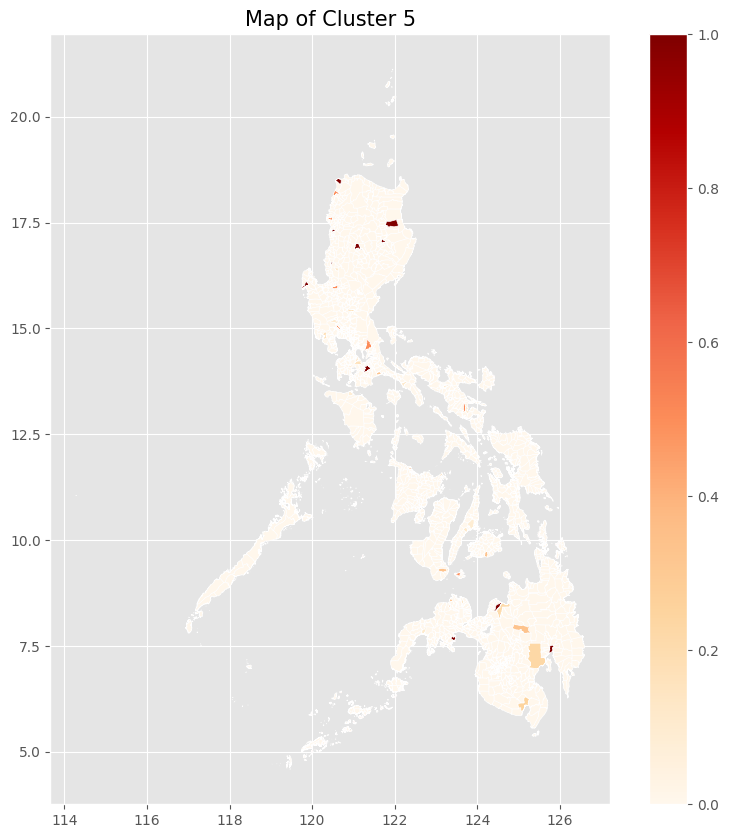

In [ ]:
# 繪製地圖
fig, ax = plt.subplots(figsize=(10, 10))
merged_gdf.plot(column=5, cmap='OrRd', legend=True, ax=ax, edgecolor='white')

ax.set_title('Map of Cluster 5', fontsize=15)
plt.show()

In [ ]:
merged_gdf[['city_mapped', 1, 2, 3, 4, 5]].sort_values(by = 5, ascending = False).head(30)

,city_mapped,1,2,3,4,5
479,Cainta,0.000000,0.00,0.000000,0.000000,1.000000
1055,San Pablo,0.000000,0.00,0.000000,0.000000,1.000000
64,Burgos,0.000000,0.00,0.000000,0.000000,1.000000
1184,Tagum,0.000000,0.00,0.000000,0.000000,1.000000
26,Burgos,0.000000,0.00,0.000000,0.000000,1.000000
1396,Burgos,0.000000,0.00,0.000000,0.000000,1.000000
1169,Opol,0.000000,0.00,0.000000,0.000000,1.000000
164,Burgos,0.000000,0.00,0.000000,0.000000,1.000000
92,Burgos,0.000000,0.00,0.000000,0.000000,1.000000
192,San Pablo,0.000000,0.00,0.000000,0.000000,1.000000
